#Read

In [11]:
# from google.colab import drive
import pandas as pd
# drive.mount('/content/drive')

file_path_2022 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Classification-new (1).csv"
file_path_2024 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Classification (1).csv"

df_2024 = pd.read_csv(file_path_2024)
df_2022 = pd.read_csv(file_path_2022)

df = pd.concat([df_2024, df_2022], ignore_index=True)
df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])


In [3]:
df

,Name,Price,Side,Volume,Order_Executed,Target,day,month,year,hour,minute,second,day_of_week,time
0,84765908,6400000.0,1,1,0,0,3,3,2024,7,45,14,1,2024-03-03 07:45:14
1,84765353,26600000.0,0,1,0,0,3,3,2024,7,45,14,1,2024-03-03 07:45:14
2,84765395,10000.0,0,1,0,0,3,3,2024,7,45,14,1,2024-03-03 07:45:14
3,84842517,16600000.0,0,1,0,0,3,3,2024,7,45,14,1,2024-03-03 07:45:14
4,84805688,10000.0,0,1,0,0,3,3,2024,7,45,14,1,2024-03-03 07:45:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27189557,1184928,930900.0,0,3605,1,0,4,5,2023,14,31,7,5,2023-05-04 14:31:07
27189558,1184928,930800.0,1,11078,1,0,4,5,2023,14,31,7,5,2023-05-04 14:31:07
27189559,1184928,930800.0,0,11078,1,0,4,5,2023,14,31,7,5,2023-05-04 14:31:07
27189560,1184928,930800.0,1,71797,1,0,4,5,2023,14,31,7,5,2023-05-04 14:31:07


In [4]:
print(df.isna().sum())

Name              0
Price             0
Side              0
Volume            0
Order_Executed    0
Target            0
day               0
month             0
year              0
hour              0
minute            0
second            0
day_of_week       0
dtype: int64


In [3]:
percentages = df['Order_Executed'].value_counts(normalize=True) * 100
print(percentages)

Order_Executed
1    86.712129
0    13.287871
Name: proportion, dtype: float64


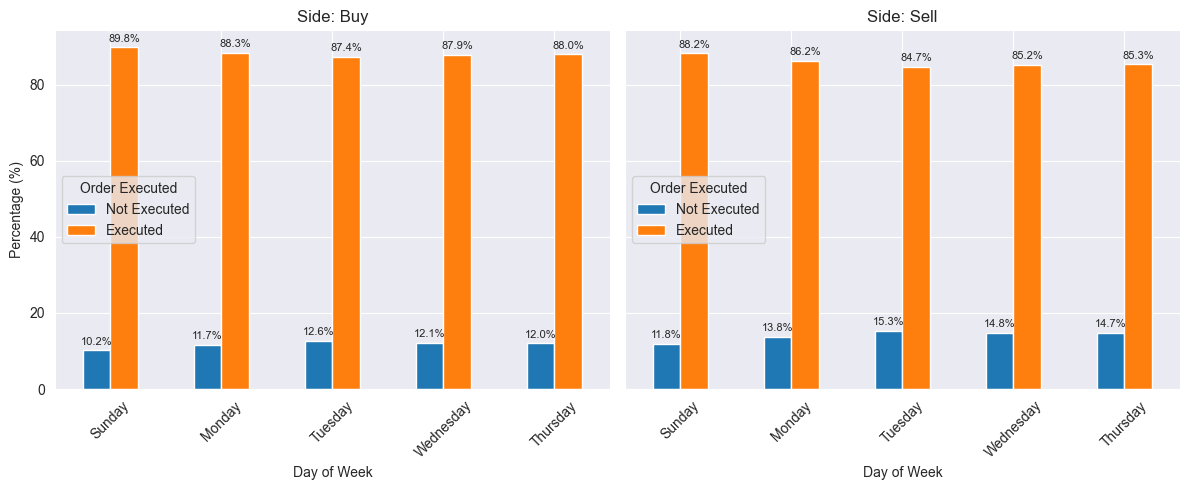

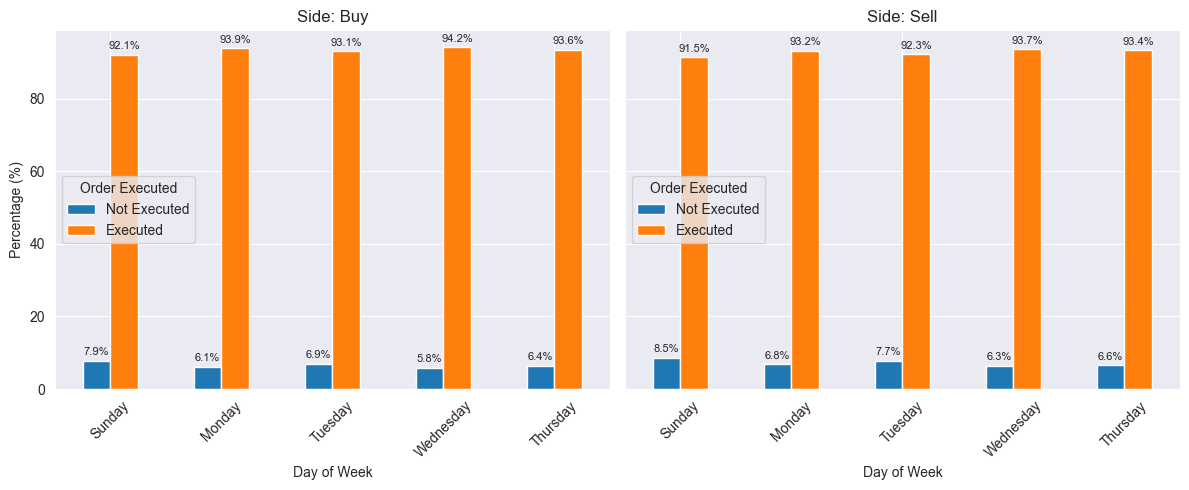

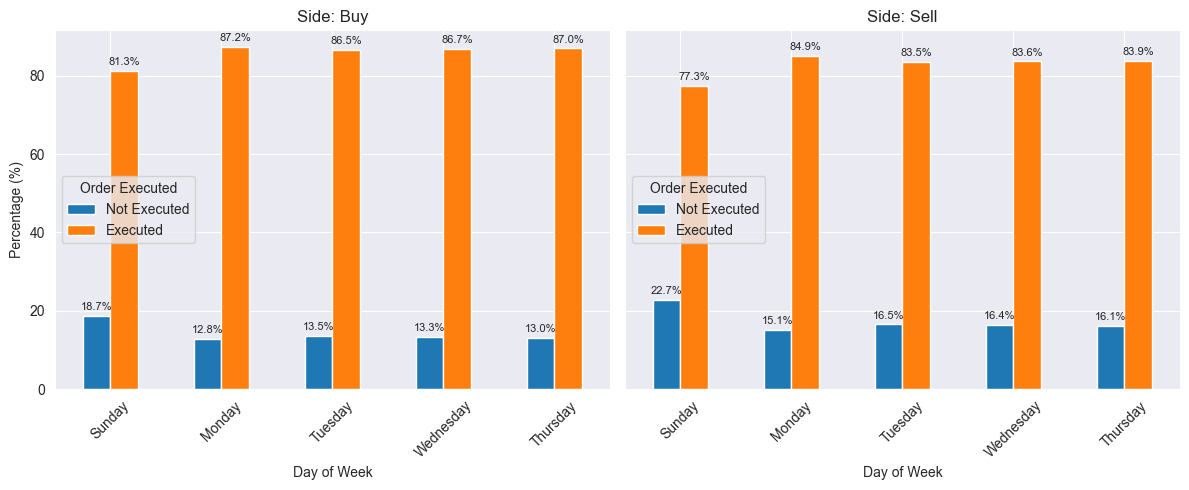

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_best_day(df):

    # Group and calculate percentage
    grouped = df.groupby(['Side', 'day_of_week', 'Order_Executed']).size().reset_index(name='count')
    total_per_group = grouped.groupby(['Side', 'day_of_week'])['count'].transform('sum')
    grouped['percentage'] = 100 * grouped['count'] / total_per_group

    # Mapping
    side_map = {0: 'Buy', 1: 'Sell'}
    day_map = {
        1: 'Sunday', 2: 'Monday', 3: 'Tuesday',
        4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'
    }
    filtered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday']

    # Apply mappings
    grouped['Side'] = grouped['Side'].map(side_map)
    grouped['day_of_week'] = grouped['day_of_week'].map(day_map)

    # Filter days
    grouped = grouped[grouped['day_of_week'].isin(filtered_days)]

    # Filter out sides with no data
    sides = grouped['Side'].unique()
    sides = [s for s in sides if not grouped[grouped['Side'] == s].empty]

    # Plot
    fig, axes = plt.subplots(1, len(sides), figsize=(12, 5), sharey=True)

    for i, side in enumerate(sides):
        side_data = grouped[grouped['Side'] == side]
        pivot = side_data.pivot(index='day_of_week', columns='Order_Executed', values='percentage').fillna(0)
        pivot = pivot.reindex(filtered_days)
        pivot.rename(columns={0: 'Not Executed', 1: 'Executed'}, inplace=True)

        ax = axes[i]
        bars = pivot.plot(kind='bar', stacked=False, ax=ax, title=f'Side: {side}')

        for bar_container in bars.containers:
            for bar in bar_container:
                height = bar.get_height()
                if height > 0:
                    bars.text(
                        bar.get_x() + bar.get_width() / 2,
                        height + 1,
                        f'{height:.1f}%',
                        ha='center',
                        va='bottom',
                        fontsize=8
                    )

        ax.set_ylabel('Percentage (%)' if i == 0 else "")
        ax.set_xlabel('Day of Week')
        ax.legend(title='Order Executed')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()



plot_best_day(df)
plot_best_day(df_2024)
plot_best_day(df_2022)

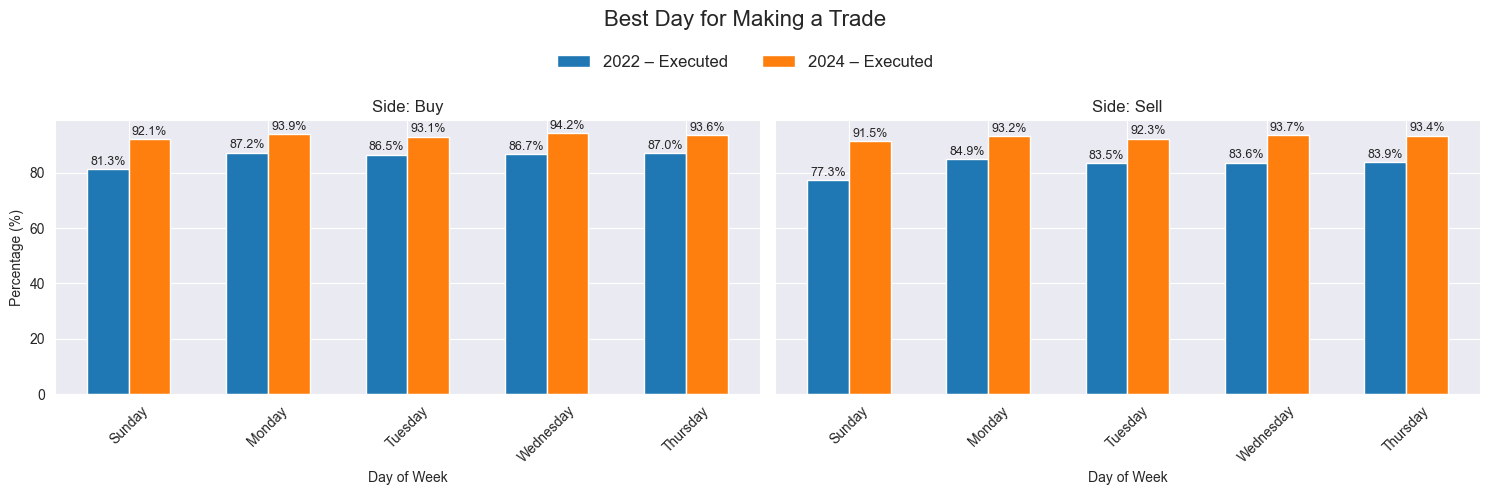

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_best_day_compare(df_all, df_2024,
                          label_all='2022', label_2024='2024'):
    """
    Grouped bar-chart comparison with value labels:
    - Two bars per weekday: (All-Executed, 2024-Executed)
    - Separate panels for Buy / Sell sides
    """

    # ---------- helpers ----------
    side_map = {0: 'Buy', 1: 'Sell'}
    day_map  = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday',
                4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
    days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday']

    def prep(df, tag):
        g = (df.groupby(['Side', 'day_of_week', 'Order_Executed'])
               .size()
               .reset_index(name='cnt'))
        g['pct'] = 100 * g['cnt'] / g.groupby(['Side', 'day_of_week'])['cnt'].transform('sum')
        g['Dataset'] = tag
        g['Side'] = g['Side'].map(side_map)
        g['day_of_week'] = g['day_of_week'].map(day_map)
        return g[g['day_of_week'].isin(days)]

    # prepare both datasets
    df_a = prep(df_all , label_all)
    df_b = prep(df_2024, label_2024)

    # combine and drop "Not Executed" rows
    data = pd.concat([df_a, df_b], ignore_index=True)
    data = data[data['Order_Executed'] == 1]

    # ---------- colour palette ----------
    palette = {
        (label_all , 1): '#1f77b4',   # deep blue
        (label_2024, 1): '#ff7f0e',   # deep orange
    }

    sides  = sorted(data['Side'].unique())
    n_days = len(days)
    bar_w  = 0.3
    idx    = np.arange(n_days)
    offsets = {
        (label_all , 1): -bar_w/2,
        (label_2024, 1):  bar_w/2
    }

    fig, axes = plt.subplots(1, len(sides), figsize=(15, 5), sharey=True)
    fig.suptitle("Best Day for Making a Trade", fontsize=16, y=0.98)

    if len(sides) == 1:
        axes = [axes]

    legend_done = set()

    for ax, side in zip(axes, sides):
        sub = data[data['Side'] == side]
        for ds, grp in sub.groupby('Dataset'):
            pivot = (grp.pivot(index='day_of_week',
                               columns='Order_Executed',
                               values='pct')
                        .reindex(days)
                        .fillna(0))
            pct_vals = pivot[1].values
            x_vals   = idx + offsets[(ds, 1)]

            label = f'{ds} – Executed'
            bars = ax.bar(x_vals,
                          pct_vals,
                          width=bar_w,
                          color=palette[(ds, 1)],
                          label=label if label not in legend_done else None)
            for bar, pct in zip(bars, pct_vals):
                ax.text(bar.get_x() + bar.get_width()/2,
                        bar.get_height() + 0.5,
                        f'{pct:.1f}%',
                        ha='center', va='bottom', fontsize=9)
            legend_done.add(label)

        ax.set_title(f'Side: {side}')
        ax.set_xticks(idx)
        ax.set_xticklabels(days, rotation=45)
        ax.set_xlabel('Day of Week')
        if side == sides[0]:
            ax.set_ylabel('Percentage (%)')

    # place legend just below the suptitle
    fig.legend(loc='upper center',
               bbox_to_anchor=(0.5, 0.92),
               ncol=2,
               frameon=False,
               fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()

# -------- run --------
plot_best_day_compare(df_2022, df_2024)


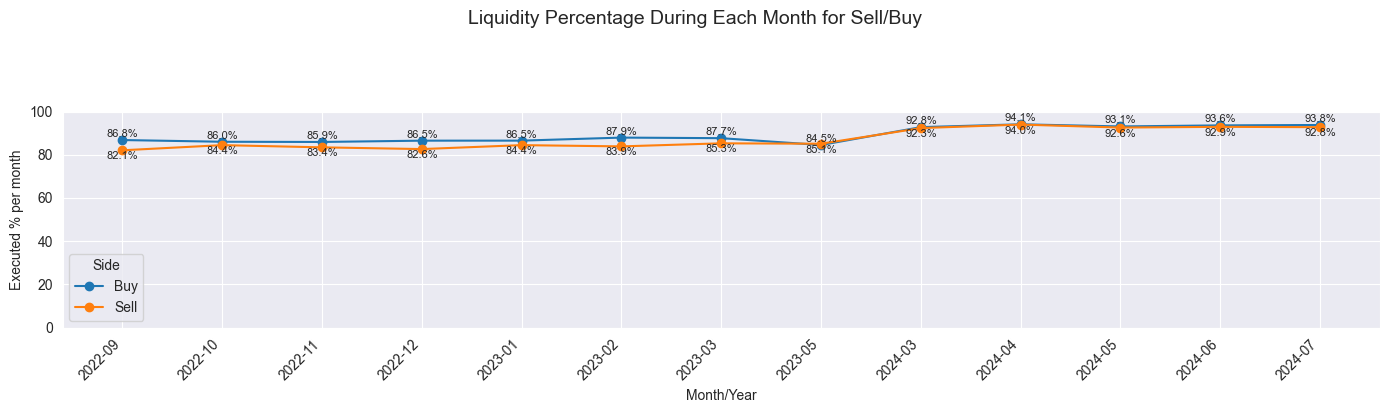

In [20]:
# ── 2.  Plot (combined) with offset labels & title ─────
fig, ax = plt.subplots(figsize=(14, 4))
fig.suptitle("Liquidity Percentage During Each Month for Sell/Buy",
             fontsize=14, y=1.02)

for side, label in zip([0, 1], ['Buy', 'Sell']):
    s = monthly[monthly['Side'] == side].sort_values('month')
    x = range(len(s))
    ax.plot(x, s['pct'], marker='o', label=label)
    ax.set_xticks(x)
    ax.set_xticklabels(s['month'].dt.strftime('%Y-%m'),
                       rotation=45, ha='right')

    # side-based offsets to avoid overlap
    dy = 0.5 if label == 'Buy' else -0.5
    va = 'bottom' if label == 'Buy' else 'top'

    for xi, yi in zip(x, s['pct']):
        ax.text(xi, yi + dy,
                f"{yi:.1f}%",
                ha='center', va=va,
                fontsize=8)

ax.set_xlabel("Month/Year")
ax.set_ylabel("Executed % per month")
ax.set_ylim(0, 100)
ax.legend(title="Side")
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


#Analytics and Pre-Process

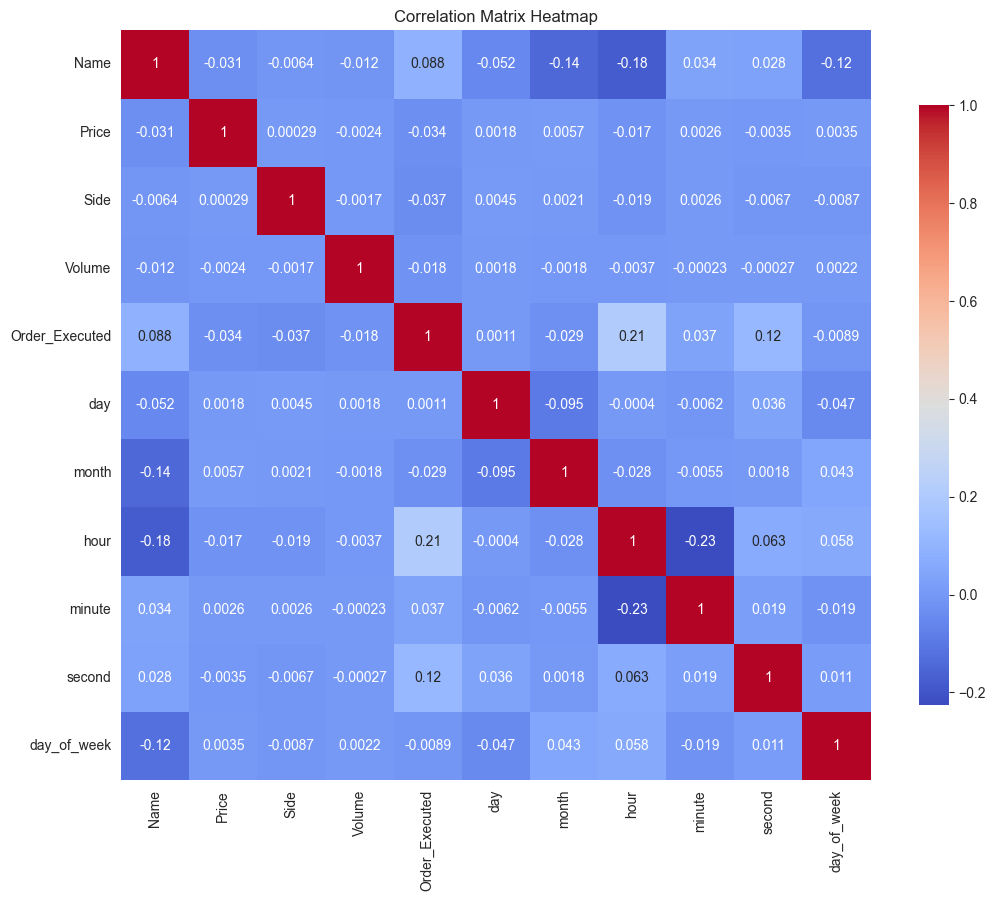

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.drop(columns=['Target','year']).corr()

# Plotting the heatmap for the correlation matrix with a larger figure size
plt.figure(figsize=(11, 9))  # Make the figure larger as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True,
            cbar_kws={"shrink": 0.8}, xticklabels=1, yticklabels=1)  # Control label density and stretch
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()  # Adjust layout to fill space
plt.show()

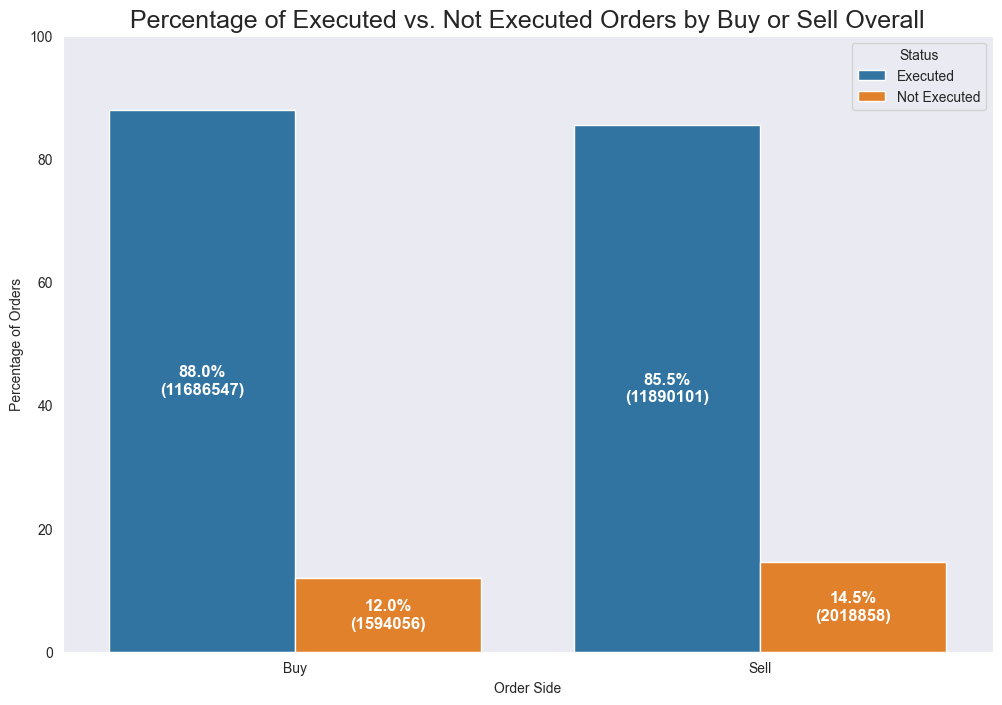

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a 'Status' column to represent executed and non-executed orders
df['Status'] = df['Order_Executed'].apply(lambda x: 'Executed' if x == 1 else 'Not Executed')

# Group by 'Side' and 'Status' and calculate counts
side_status_counts = df.groupby(['Side', 'Status']).size().unstack().fillna(0)

# Calculate percentage within each side (Buy or Sell)
side_status_percent = side_status_counts.div(side_status_counts.sum(axis=1), axis=0) * 100

# Reset index for plotting
side_status_percent = side_status_percent.reset_index().melt(id_vars='Side', var_name='Status', value_name='Percentage')
side_status_counts = side_status_counts.reset_index().melt(id_vars='Side', var_name='Status', value_name='Count')

# Merge counts and percentages for annotation and reset the index
side_status_data = pd.merge(side_status_percent, side_status_counts, on=['Side', 'Status']).reset_index(drop=True)
side_status_data['Side'] = side_status_data['Side'].map({0: 'Buy', 1: 'Sell'})
# Plot
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Side', y='Percentage', hue='Status', data=side_status_data, palette=['#1f77b4', '#ff7f0e'])

# Annotate each bar with percentage and count
for i, bar in enumerate(bar_plot.patches):
    try:
      # Get the height (percentage) of each bar and corresponding count
      height = bar.get_height()
      count = side_status_data.loc[i, 'Count']  # Access count using .loc

      # Display percentage and count inside each bar
      bar_plot.text(
          bar.get_x() + bar.get_width() / 2,
          height / 2,  # Position text in the middle of the bar
          f'{height:.1f}%\n({int(count)})',
          ha='center',
          va='center',
          color='white',
          fontsize=12,
          fontweight='bold'
      )
    except:
      continue

plt.title(
    'Percentage of Executed vs. Not Executed Orders by Buy or Sell Overall',
    fontsize=18
)
plt.xlabel('Order Side')
plt.ylabel('Percentage of Orders')
plt.ylim(0, 100)  # Set y-axis to 100% max
plt.legend(title='Status')
plt.grid(axis='y')

plt.show()


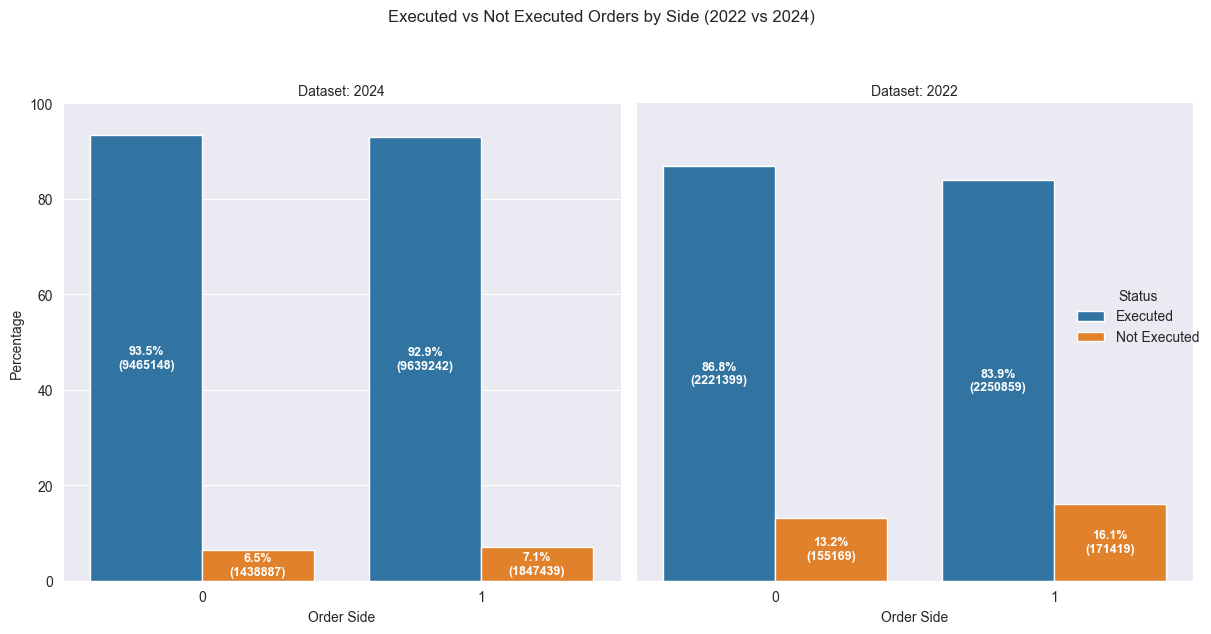

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def prepare_plot_data(df, label):
    df['Status'] = df['Order_Executed'].apply(lambda x: 'Executed' if x == 1 else 'Not Executed')
    counts = df.groupby(['Side', 'Status']).size().unstack().fillna(0)
    percent = counts.div(counts.sum(axis=1), axis=0) * 100

    percent = percent.reset_index().melt(id_vars='Side', var_name='Status', value_name='Percentage')
    counts = counts.reset_index().melt(id_vars='Side', var_name='Status', value_name='Count')

    merged = pd.merge(percent, counts, on=['Side', 'Status']).reset_index(drop=True)
    merged['Dataset'] = label
    return merged

# Prepare and combine
plot_data_2024 = prepare_plot_data(df_2024.copy(), '2024')
plot_data_2022 = prepare_plot_data(df_2022.copy(), '2022')
combined_data = pd.concat([plot_data_2024, plot_data_2022])

# Use catplot for faceted barplot
g = sns.catplot(
    data=combined_data,
    kind='bar',
    x='Side', y='Percentage',
    hue='Status',
    col='Dataset',
    palette=['#1f77b4', '#ff7f0e'],
    height=6, aspect=0.9
)

# Annotate each subplot
for ax, (_, subdata) in zip(g.axes.flat, combined_data.groupby('Dataset')):
    for bars, (_, row) in zip(ax.patches, subdata.iterrows()):
        height = bars.get_height()
        ax.text(
            bars.get_x() + bars.get_width() / 2,
            height / 2,
            f"{height:.1f}%\n({int(row['Count'])})",
            ha='center', va='center',
            color='white', fontsize=9, fontweight='bold'
        )

g.set_titles("Dataset: {col_name}")
g.set_axis_labels("Order Side", "Percentage")
g.fig.suptitle("Executed vs Not Executed Orders by Side (2022 vs 2024)", y=1.05)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


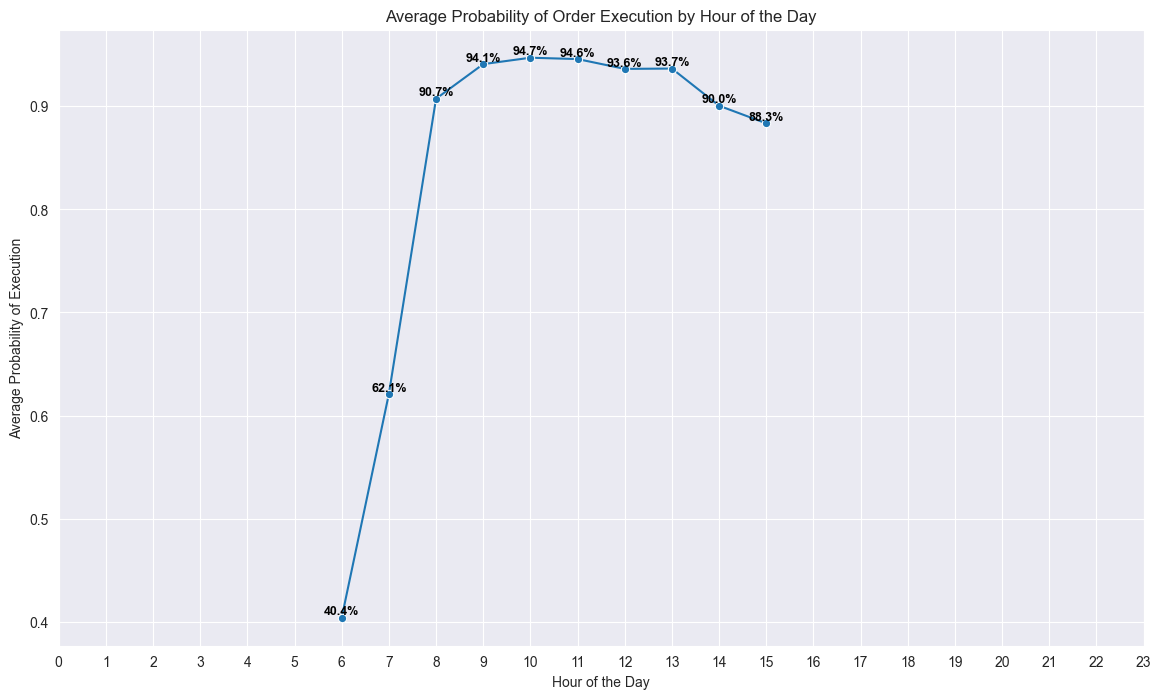

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Group by hour and calculate mean probability of execution
hourly_data = df.groupby('hour')['Order_Executed'].mean().reset_index()

plt.figure(figsize=(14, 8))
line_plot = sns.lineplot(x='hour', y='Order_Executed', data=hourly_data, marker='o')
plt.title('Average Probability of Order Execution by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Probability of Execution')
plt.xticks(range(0, 24))
plt.grid(True)

# Annotate each point with the specific percentage
for i in range(len(hourly_data)):
    plt.text(
        x=hourly_data['hour'][i],
        y=hourly_data['Order_Executed'][i],
        s=f"{hourly_data['Order_Executed'][i] * 100:.1f}%",  # Convert to percentage
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color='black'
    )

plt.show()


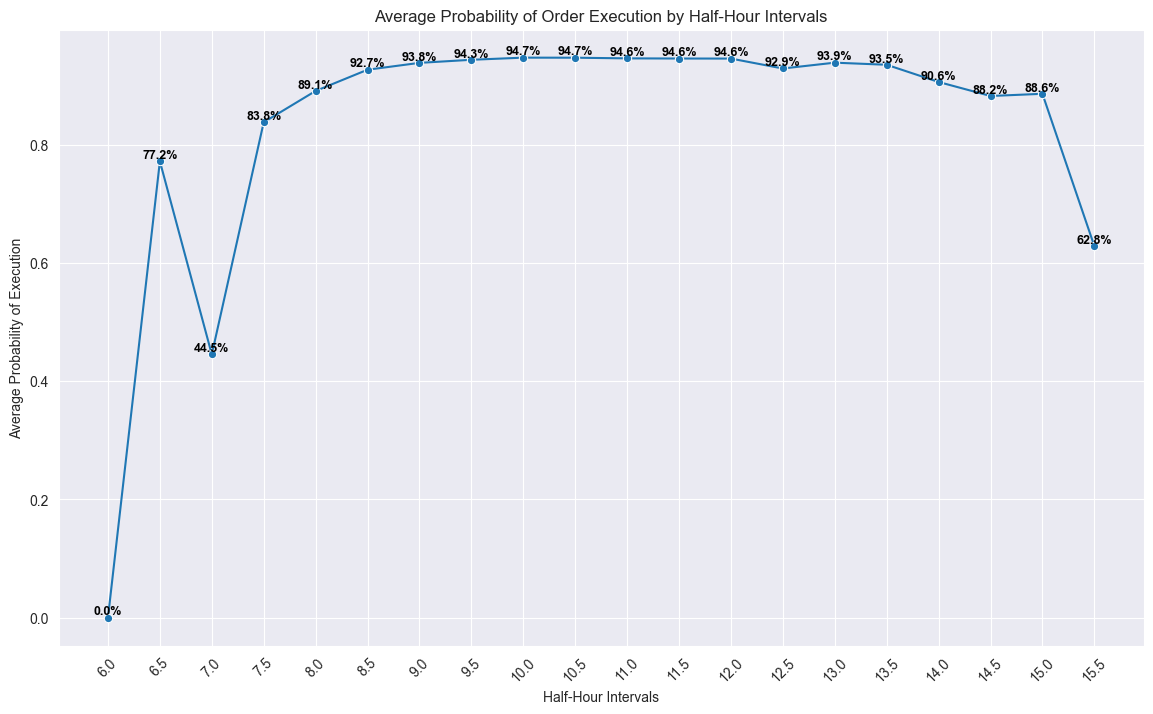

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column 'Half_Hour' based on 'Hour' and 'Minute'
df['Half_Hour'] = df['hour'] + (df['minute'] >= 30) * 0.5

# Group by 'Half_Hour' and calculate the mean probability of execution
half_hourly_data = df.groupby('Half_Hour')['Order_Executed'].mean().reset_index()

# Plot
plt.figure(figsize=(14, 8))
line_plot = sns.lineplot(x='Half_Hour', y='Order_Executed', data=half_hourly_data, marker='o')
plt.title('Average Probability of Order Execution by Half-Hour Intervals')
plt.xlabel('Half-Hour Intervals')
plt.ylabel('Average Probability of Execution')
plt.xticks(half_hourly_data['Half_Hour'], rotation=45)
plt.grid(True)

# Annotate each point with the specific percentage
for i in range(len(half_hourly_data)):
    plt.text(
        x=half_hourly_data['Half_Hour'][i],
        y=half_hourly_data['Order_Executed'][i],
        s=f"{half_hourly_data['Order_Executed'][i] * 100:.1f}%",  # Convert to percentage
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color='black'
    )

plt.show()


#Linear Models for Classification

SGD Accuracy: 0.9335
Logistic Reg. Accuracy: 0.9340


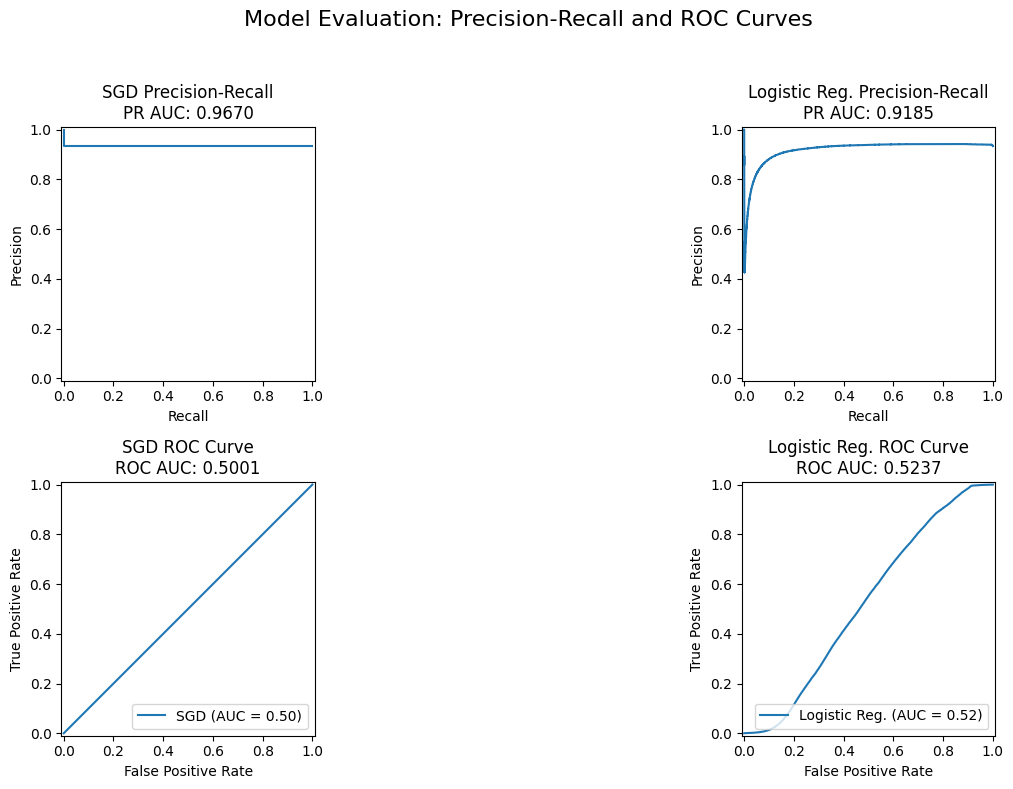

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# ——— Load and sort data ———
file_path_2022 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Classification-new (1).csv"
file_path_2024 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Classification (1).csv"

df = pd.concat([
    pd.read_csv(file_path_2022),
    pd.read_csv(file_path_2024)
], ignore_index=True)
data = df.sort_values(by=['year', 'month', 'day', 'hour', 'minute', 'second'])

# --- feature engineering (step 1 from earlier advice) -------------
data['log_price']   = np.log1p(data['Price'])
data['log_volume']  = np.log1p(data['Volume'])
data['notional']    = data['Price'] * data['Volume']

# cyclic time encoding
data['hour_sin']    = np.sin(2 * np.pi * data['hour']   / 24)
data['hour_cos']    = np.cos(2 * np.pi * data['hour']   / 24)
data['min_sin']     = np.sin(2 * np.pi * data['minute'] / 60)
data['min_cos']     = np.cos(2 * np.pi * data['minute'] / 60)


# ---------- 1. Volume buckets (deciles) ----------
data['vol_bucket'] = pd.qcut(data['Volume'], 10, labels=False, duplicates='drop')

# one-hot buckets (keeps raw bucket idx too, drop if you wish)
vol_dummies = pd.get_dummies(data['vol_bucket'], prefix='vol_bin')
data = pd.concat([data, vol_dummies], axis=1)

# ---------- 2. Price context per Name ----------
# build a proper timestamp for rolling operations
data['ts'] = pd.to_datetime(dict(year=data.year,
                                 month=data.month,
                                 day=data.day,
                                 hour=data.hour,
                                 minute=data.minute,
                                 second=data.second))
data = data.sort_values(['Name', 'ts'])

# rolling 30-order mean price for each Name (shift → no info leak)
data['price_mean_30'] = (data
    .groupby('Name')['Price']
    .transform(lambda s: s.shift().rolling(30, min_periods=1).mean())
)
data['price_rel'] = data['Price'] / data['price_mean_30']

# ---------- 3. Rolling execution rate per Name ----------
data['roll_exec_rate_30'] = (data
    .groupby('Name')['Order_Executed']
    .transform(lambda s: s.shift().rolling(30, min_periods=1).mean())
)

# ---------- clean-up ----------
# drop helper cols you don’t want models to see
data = data.drop(columns=['ts'])                 # raw timestamp not needed
# NaNs from early rolling windows → 0
data = data.fillna(0)


# optional: drop noisy / redundant columns
data = data.drop(columns=['second'])          # rarely useful granularity


# ——— Prepare features & target ———

X = data.drop(columns=['Order_Executed'])
y = data['Order_Executed']

# ——— Time-based split: last 10% as test ———
split_index = int(len(X) * 0.9)
X_main, X_test = X[:split_index], X[split_index:]
y_main, y_test = y[:split_index], y[split_index:]

# ——— Random validation split from the main set ———
X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size=0.1, random_state=42
)

# ——— Define models ———
models = {
     'SGD'      : SGDClassifier(
        loss='log_loss',    # ← was 'log'
        max_iter=200,
        tol=1e-3,
        random_state=42),
    'Logistic Reg.': LogisticRegression(
        max_iter=2000, n_jobs=-1
    )
}


# right after you define models, grab the “default” size:

# Fit all models first
for name, model in models.items():
    model.fit(X_train, y_train)

import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc,
    PrecisionRecallDisplay, RocCurveDisplay,accuracy_score
)

# Use default (clean) style
plt.rcdefaults()

plt.figure(figsize=(16, 8))
plt.suptitle('Model Evaluation: Precision-Recall and ROC Curves', fontsize=16)

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    # Precision-Recall
    ax_pr = plt.subplot(2, len(models), i + 1)
    ax_pr.clear()
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax_pr)
    ax_pr.set_title(f'{name} Precision-Recall\nPR AUC: {pr_auc:.4f}')
    ax_pr.grid(False)

    # ROC
    ax_roc = plt.subplot(2, len(models), i + 1 + len(models))
    ax_roc.clear()
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=ax_roc)
    ax_roc.set_title(f'{name} ROC Curve\nROC AUC: {roc_auc:.4f}')
    ax_roc.grid(False)
    print(f"{name} Accuracy: {acc:.4f}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



#ML for Classification


Training and evaluating LightGBM…
[LightGBM] [Info] Number of positive: 18793489, number of negative: 3230055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2383
[LightGBM] [Info] Number of data points in the train set: 22023544, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.853336 -> initscore=1.761011
[LightGBM] [Info] Start training from score 1.761011
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.854666	valid_0's binary_logloss: 0.26866
[CV] 5-fold ROC-AUC: 0.9694 ± 0.0211
[Boot] 95 % CI for test ROC-AUC: 0.5221 – 0.5253
LightGBM Accuracy: 0.9340


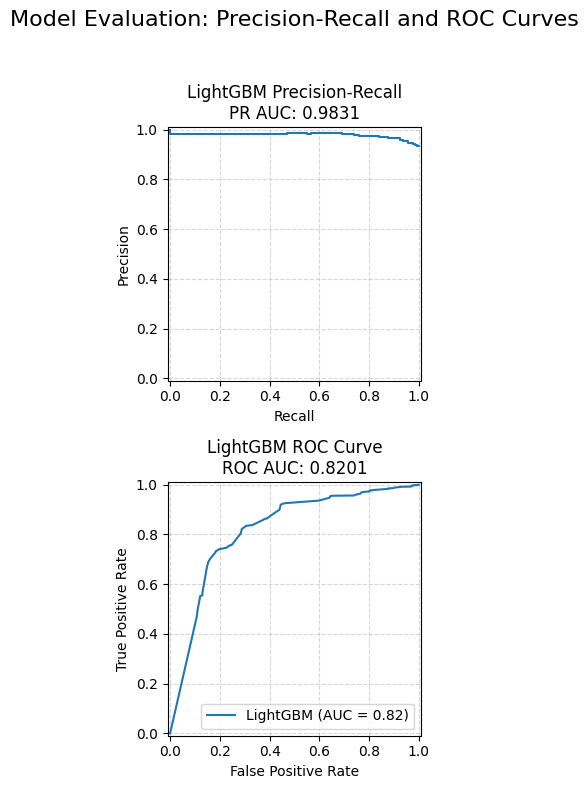

In [47]:
# ── 0. Imports & global style ──────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
import inspect

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_curve, roc_curve, auc,
    RocCurveDisplay, PrecisionRecallDisplay,roc_auc_score
)
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping            # XGB early-stop callback
from xgboost.callback import EvaluationMonitor   # keep this import
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.utils import resample

plt.style.use("default")                              # white bg, visible axes


# ── 1. Load & merge data (time-ordered) ────────────────────────────────────
fp22 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Classification-new (1).csv"
fp24 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Classification (1).csv"

data = pd.concat([pd.read_csv(fp22), pd.read_csv(fp24)], ignore_index=True)
data = data.sort_values(by=['year', 'month', 'day', 'hour', 'minute', 'second'])

# --- feature engineering (step 1 from earlier advice) -------------
data['log_price']   = np.log1p(data['Price'])
data['log_volume']  = np.log1p(data['Volume'])
data['notional']    = data['Price'] * data['Volume']

# cyclic time encoding
data['hour_sin']    = np.sin(2 * np.pi * data['hour']   / 24)
data['hour_cos']    = np.cos(2 * np.pi * data['hour']   / 24)
data['min_sin']     = np.sin(2 * np.pi * data['minute'] / 60)
data['min_cos']     = np.cos(2 * np.pi * data['minute'] / 60)


# ---------- 1. Volume buckets (deciles) ----------
data['vol_bucket'] = pd.qcut(data['Volume'], 10, labels=False, duplicates='drop')

# one-hot buckets (keeps raw bucket idx too, drop if you wish)
vol_dummies = pd.get_dummies(data['vol_bucket'], prefix='vol_bin')
data = pd.concat([data, vol_dummies], axis=1)

# ---------- 2. Price context per Name ----------
# build a proper timestamp for rolling operations
data['ts'] = pd.to_datetime(dict(year=data.year,
                                 month=data.month,
                                 day=data.day,
                                 hour=data.hour,
                                 minute=data.minute,
                                 second=data.second))
data = data.sort_values(['Name', 'ts'])

# rolling 30-order mean price for each Name (shift → no info leak)
data['price_mean_30'] = (data
    .groupby('Name')['Price']
    .transform(lambda s: s.shift().rolling(30, min_periods=1).mean())
)
data['price_rel'] = data['Price'] / data['price_mean_30']

# ---------- 3. Rolling execution rate per Name ----------
data['roll_exec_rate_30'] = (data
    .groupby('Name')['Order_Executed']
    .transform(lambda s: s.shift().rolling(30, min_periods=1).mean())
)

# ---------- clean-up ----------
# drop helper cols you don’t want models to see
data = data.drop(columns=['ts'])                 # raw timestamp not needed
# NaNs from early rolling windows → 0
data = data.fillna(0)


# optional: drop noisy / redundant columns
data = data.drop(columns=['second'])          # rarely useful granularity



X = data.drop(columns=['Order_Executed'])
y = data['Order_Executed']


# ── 2. Time-based split: 80 % train | 10 % val (random) | 10 % test ───────
split_idx = int(len(X) * 0.9)             # last 10 % → test
X_main, X_test  = X.iloc[:split_idx],  X.iloc[split_idx:]
y_main, y_test  = y.iloc[:split_idx],  y.iloc[split_idx:]

X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size=0.1, random_state=42, shuffle=False
)

pos = y_train.sum()                     # number of 1-labels
neg = len(y_train) - pos
scale_pos = neg / pos

# ── 3. Define models ───────────────────────────────────────────────────────
models = {
#     "XGBoost": xgb.XGBClassifier(
#     scale_pos_weight=scale_pos,
#     use_label_encoder=False,
#     eval_metric="auc",
#     learning_rate=0.05,
#     n_estimators=600,      # give it room to learn slowly
#     max_depth=5,
#     random_state=42,
#     n_jobs=-1,
#     verbosity=0,
#     early_stopping_rounds=10,
# ),
    "LightGBM": lgb.LGBMClassifier(
    learning_rate=0.05,
    n_estimators=600,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)}

# detect whether current XGBoost version supports the callbacks kwarg
xgb_accepts_callbacks = "callbacks" in inspect.signature(
    xgb.XGBClassifier.fit
).parameters


# ── 4. Train, evaluate, plot ──────────────────────────────────────────────
plt.figure(figsize=(16, 8))
plt.suptitle("Model Evaluation: Precision-Recall and ROC Curves", fontsize=16)

for i, (name, model) in enumerate(models.items()):
    print(f"\nTraining and evaluating {name}…")

    # ― fit with the right early-stopping API ―
    if name == "LightGBM":
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            callbacks=[
                lgb.early_stopping(10)          # stop after 3 stagnant rounds
            ]
        )
        # 1. out-of-time cross-val on the full dataset
        tscv = TimeSeriesSplit(n_splits=5)
        cv_auc = cross_val_score(model, X, y,
                                 cv=tscv, scoring="roc_auc", n_jobs=-1)
        print(f"[CV] 5-fold ROC-AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")

        # 2. bootstrap CI on test set
        boot = []
        for _ in range(1000):
            idx = resample(np.arange(len(y_test)))
            boot.append(roc_auc_score(y_test.iloc[idx], y_prob[idx]))
        lo, hi = np.percentile(boot, [2.5, 97.5])
        print(f"[Boot] 95 % CI for test ROC-AUC: {lo:.4f} – {hi:.4f}")

    else:  # XGBoost
        model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)]
    )

    # ― predictions ―
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

    # ― Precision-Recall plot ―
    ax_pr  = plt.subplot(2, len(models), i + 1)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax_pr)
    ax_pr.set_title(f"{name} Precision-Recall\nPR AUC: {pr_auc:.4f}")
    ax_pr.grid(True, linestyle="--", alpha=0.5)

    # ― ROC plot ―
    ax_roc = plt.subplot(2, len(models), i + 1 + len(models))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                    estimator_name=name).plot(ax=ax_roc)
    ax_roc.set_title(f"{name} ROC Curve\nROC AUC: {roc_auc:.4f}")
    ax_roc.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#Taking LightGBM. We will run optuna on it to get the best MODEL

In [15]:
# ── 0. Imports & data ───────────────────────────────────────────────────────
import pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from xgboost import XGBClassifier
import optuna

fp22 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Classification-new (1).csv"
fp24 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Classification (1).csv"

data = pd.concat([pd.read_csv(fp22), pd.read_csv(fp24)], ignore_index=True)
X, y = data.drop(columns=["Order_Executed"]), data["Order_Executed"]

# ── 1. 80 / 10 / 10 split (last 10 % = TEST) ───────────────────────────────
n_test   = int(0.10 * len(data))
val_frac = 0.10 / 0.90

X_test, y_test = X.iloc[-n_test:], y.iloc[-n_test:]
X_tv,   y_tv   = X.iloc[:-n_test], y.iloc[:-n_test]

X_tr, X_val, y_tr, y_val = train_test_split(
    X_tv, y_tv, test_size=val_frac, shuffle=True, stratify=y_tv, random_state=42
)

# ── 2. Optuna objective ────────────────────────────────────────────────────
def objective(trial):
    params = {
        "max_depth"        : trial.suggest_int("max_depth", 4, 12),
        "learning_rate"    : trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        "gamma"            : trial.suggest_float("gamma", 0.0, 5.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators"     : 1000,
        "subsample"        : 1.0,
        "eval_metric"      : "logloss",
        "early_stopping_rounds": 50,
        "use_label_encoder": False,
        "random_state"     : 42,
        "n_jobs"           : -1,
    }
    mdl = XGBClassifier(**params)
    mdl.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    return accuracy_score(y_val, mdl.predict(X_val))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1, show_progress_bar=False)

best = study.best_params | {
    "n_estimators"           : 1000,
    "subsample"              : 1.0,
    "eval_metric"            : "logloss",
    "early_stopping_rounds"  : 50,
    "use_label_encoder"      : False,
    "random_state"           : 42,
    "n_jobs"                 : -1,
}

# ── 3. Final model on TR+VAL → TEST ─────────────────────────────────────────
final = XGBClassifier(**best)
final.fit(pd.concat([X_tr, X_val]), pd.concat([y_tr, y_val]),
          eval_set=[(X_val, y_val)], verbose=False)

proba = final.predict_proba(X_test)[:, 1]
pred  = (proba > .5).astype(int)
t_acc = accuracy_score(y_test, pred)

# ── 4. 10-fold CV on TR+VAL ────────────────────────────────────────────────
skf = StratifiedKFold(10, shuffle=True, random_state=42)
cv_true, cv_prob = [], []

for tr_idx, vl_idx in skf.split(X_tv, y_tv):
    m = XGBClassifier(**best)
    m.fit(X_tv.iloc[tr_idx], y_tv.iloc[tr_idx],
          eval_set=[(X_tv.iloc[vl_idx], y_tv.iloc[vl_idx])],
          verbose=False)
    cv_true.extend(y_tv.iloc[vl_idx])
    cv_prob.extend(m.predict_proba(X_tv.iloc[vl_idx])[:, 1])

cv_pred = (pd.Series(cv_prob) > .5).astype(int)
cv_acc  = accuracy_score(cv_true, cv_pred)

# ── 5. Quick plots ─────────────────────────────────────────────────────────
plt.figure(figsize=(12, 5)); plt.suptitle(f"TEST Accuracy {t_acc:.4f}", fontsize=14)

plt.subplot(1, 2, 1)
pr, rc, _ = precision_recall_curve(y_test, proba)
PrecisionRecallDisplay(pr, rc).plot(ax=plt.gca())
plt.title(f"PR-AUC {auc(rc, pr):.4f}")

plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, proba)
RocCurveDisplay(fpr, tpr, auc(fpr, tpr)).plot(ax=plt.gca())
plt.title(f"ROC-AUC {auc(fpr, tpr):.4f}")

plt.tight_layout(rect=[0, 0, 1, 0.93]); plt.show()

print(f"\nTEST  →  Acc {t_acc:.4f}")
print(f"CV    →  Acc {cv_acc:.4f}")

[I 2025-05-27 17:22:31,963] A new study created in memory with name: no-name-c50ae04e-80df-4a7a-8ae8-70525fc8dfc9
C:\Users\Shalev\PyCharmMiscProject\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:22:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
[I 2025-05-27 17:27:04,234] Trial 0 finished with value: 0.9614624284238404 and parameters: {'max_depth': 10, 'learning_rate': 0.059593741268152166, 'gamma': 2.9013249148936318, 'colsample_bytree': 0.8357049521257145}. Best is trial 0 with value: 0.9614624284238404.
C:\Users\Shalev\PyCharmMiscProject\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:27:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


KeyboardInterrupt: 

#DL for Forecasting

In [4]:
fp24 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Prediction.csv"
fp22 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Prediction-new.csv"
data = pd.concat([pd.read_csv(fp22), pd.read_csv(fp24)], ignore_index=True)

In [5]:
data

,Total_Money,Total_Volume,Avg_Stock_Price,Avg_Order_Executed,Target_0,Target_35,Target_65,Target_90,Day,Month,Year,Hour,Minute,Second,Day_Of_Week
0,4.961783e+12,268403726.0,184.862671,0.000000,10278.0,3671.0,0.0,3274.0,5.0,9.0,2022.0,6.0,29.0,59.0,2.0
1,6.568548e+11,31029044.0,211.690301,0.000000,823.0,112.0,0.0,208.0,5.0,9.0,2022.0,6.0,44.0,59.0,2.0
2,3.576993e+12,88630740.0,403.583785,0.776122,7249.0,1528.0,0.0,1485.0,5.0,9.0,2022.0,6.0,59.0,59.0,2.0
3,1.500755e+12,86878992.0,172.740802,0.824327,2166.0,1950.0,0.0,869.0,5.0,9.0,2022.0,7.0,14.0,59.0,2.0
4,1.006975e+12,46204893.0,217.936803,0.712511,3680.0,1723.0,0.0,1232.0,5.0,9.0,2022.0,7.0,29.0,59.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,5.449841e+08,7935.0,686.810460,0.970062,2405.0,0.0,0.0,0.0,25.0,7.0,2024.0,13.0,44.0,59.0,5.0
5371,3.362805e+08,6015.0,559.069825,0.941411,1758.0,0.0,0.0,0.0,25.0,7.0,2024.0,13.0,59.0,59.0,5.0
5372,4.225346e+08,11457.0,368.800384,0.936570,3090.0,0.0,0.0,0.0,25.0,7.0,2024.0,14.0,14.0,59.0,5.0
5373,4.735576e+08,10972.0,431.605541,0.850525,2763.0,0.0,0.0,0.0,25.0,7.0,2024.0,14.0,29.0,59.0,5.0


Training LSTM...


Epoch 1/20: 100%|██████████| 413/413 [00:11<00:00, 37.03it/s, loss=0.0415]


Epoch 1: Train Loss=0.22136, Val Loss=0.02187


Epoch 2/20: 100%|██████████| 413/413 [00:11<00:00, 37.52it/s, loss=0.0162] 


Epoch 2: Train Loss=0.02444, Val Loss=0.01886


Epoch 3/20: 100%|██████████| 413/413 [00:11<00:00, 37.50it/s, loss=0.0189] 


Epoch 3: Train Loss=0.01629, Val Loss=0.01526


Epoch 4/20: 100%|██████████| 413/413 [00:11<00:00, 37.52it/s, loss=0.0177] 


Epoch 4: Train Loss=0.01350, Val Loss=0.02008


Epoch 5/20: 100%|██████████| 413/413 [00:11<00:00, 37.46it/s, loss=0.0215] 


Epoch 5: Train Loss=0.01261, Val Loss=0.01636


Epoch 6/20: 100%|██████████| 413/413 [00:10<00:00, 37.63it/s, loss=0.00994]


Epoch 6: Train Loss=0.01240, Val Loss=0.02480
Early stopping triggered.
Training GRU...


Epoch 1/20: 100%|██████████| 413/413 [00:19<00:00, 21.73it/s, loss=0.0863]


Epoch 1: Train Loss=0.21627, Val Loss=0.01958


Epoch 2/20: 100%|██████████| 413/413 [00:18<00:00, 22.19it/s, loss=0.0569]


Epoch 2: Train Loss=0.05369, Val Loss=0.02864


Epoch 3/20: 100%|██████████| 413/413 [00:18<00:00, 22.14it/s, loss=0.0328]


Epoch 3: Train Loss=0.03047, Val Loss=0.02457


Epoch 4/20: 100%|██████████| 413/413 [00:18<00:00, 22.19it/s, loss=0.013]  


Epoch 4: Train Loss=0.01953, Val Loss=0.01705


Epoch 5/20: 100%|██████████| 413/413 [00:18<00:00, 22.09it/s, loss=0.0122] 


Epoch 5: Train Loss=0.01524, Val Loss=0.03000


Epoch 6/20: 100%|██████████| 413/413 [00:18<00:00, 22.21it/s, loss=0.0055] 


Epoch 6: Train Loss=0.01297, Val Loss=0.02451


Epoch 7/20: 100%|██████████| 413/413 [00:18<00:00, 22.09it/s, loss=0.0217] 


Epoch 7: Train Loss=0.01180, Val Loss=0.01637


Epoch 8/20: 100%|██████████| 413/413 [00:18<00:00, 22.11it/s, loss=0.0178] 


Epoch 8: Train Loss=0.01153, Val Loss=0.02305


Epoch 9/20: 100%|██████████| 413/413 [00:18<00:00, 21.90it/s, loss=0.0182] 


Epoch 9: Train Loss=0.01103, Val Loss=0.01931


Epoch 10/20: 100%|██████████| 413/413 [00:18<00:00, 22.02it/s, loss=0.0116] 


Epoch 10: Train Loss=0.01086, Val Loss=0.01858
Early stopping triggered.
LSTM  | MSE: 0.036029  MAE: 0.172579  R²: -1.5609  MASE: 45.5237  SMAPE: 18.38%  DW: 0.11
GRU   | MSE: 0.007456  MAE: 0.068172  R²: 0.4700  MASE: 17.9827  SMAPE: 8.22%  DW: 0.60


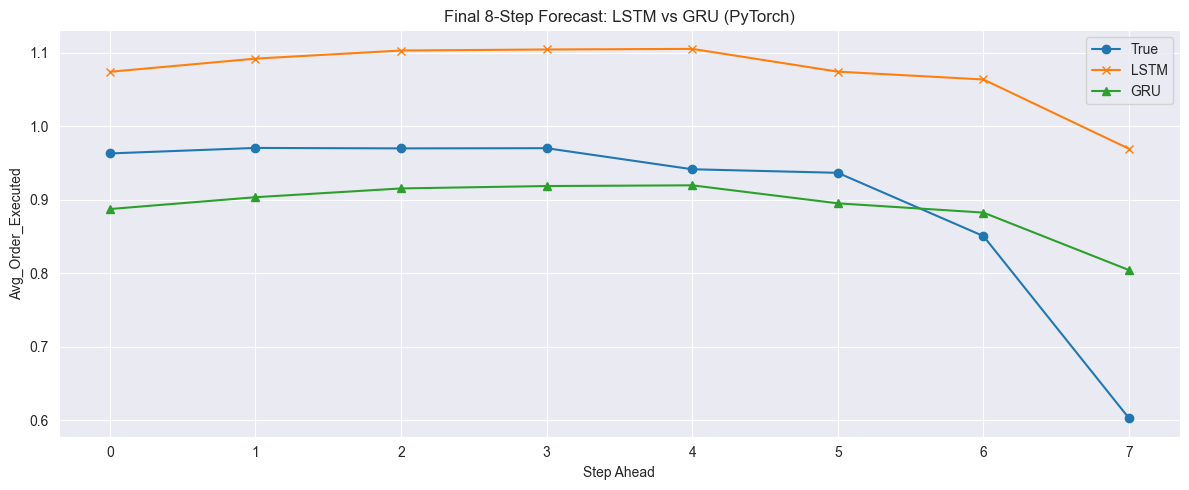

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.stattools import durbin_watson
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# ── Load & preprocess ─────────────────────────────────────────────
fp24 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Prediction.csv"
fp22 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Prediction-new.csv"
data = pd.concat([pd.read_csv(fp22), pd.read_csv(fp24)], ignore_index=True)

data["timestamp"] = pd.to_datetime({
    "year":   data["Year"],
    "month":  data["Month"],
    "day":    data["Day"],
    "hour":   data["Hour"],
    "minute": data["Minute"],
    "second": data["Second"]
})
data = (
    data.sort_values("timestamp")
        .set_index("timestamp")
        .resample("15min").mean()
        .interpolate("linear")
)

series = data["Avg_Order_Executed"].values
series_scaled = series.reshape(-1, 1) * 1000

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series_scaled).flatten()

LAGS = 120
HORIZON = 8

# ── Build lagged dataset ──────────────────────────────────────────
X, y = [], []
for i in range(len(series_scaled) - LAGS - HORIZON + 1):
    X.append(series_scaled[i:i+LAGS])
    y.append(series_scaled[i+LAGS+HORIZON-1])
X, y = np.array(X), np.array(y)

# ── Train / Val / Test split ──────────────────────────────────────
n = len(X)
train_i = int(n * 0.8)
val_i   = int(n * 0.9)

X_train, y_train = X[:train_i], y[:train_i]
X_val, y_val     = X[train_i:val_i], y[train_i:val_i]
X_test, y_test   = X[val_i:], y[val_i:]

# ── Reshape ───────────────────────────────────────────────────────
X_train_scaled = X_train.reshape(-1, LAGS, 1)
X_val_scaled   = X_val.reshape(-1, LAGS, 1)
X_test_scaled  = X_test.reshape(-1, LAGS, 1)

# ── Datasets and Loaders ─────────────────────────────────────────
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)), batch_size=128, shuffle=True)

val_loader = DataLoader(TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.float32)), batch_size=128)

# ── Model definitions ─────────────────────────────────────────────
class RNNForecast(nn.Module):
    def __init__(self, rnn_type):
        super().__init__()
        self.rnn = rnn_type(input_size=1, hidden_size=64, batch_first=True)
        self.bn = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.bn(out[:, -1])
        out = self.dropout(out)
        return self.fc(out)


def train_model(model, name):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    early_stop_count = 0
    best_model_state = None

    print(f"Training {name}...")
    for epoch in range(20):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/20")
        train_loss = 0
        for xb, yb in loop:
            optimizer.zero_grad()
            pred = model(xb).squeeze()
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb).squeeze()
                loss = loss_fn(pred, yb)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.5f}, Val Loss={val_loss:.5f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stop_count = 0
        else:
            early_stop_count += 1
            if early_stop_count >= 3:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
    return model

# ── Train LSTM and GRU ────────────────────────────────────────────
lstm_model = train_model(RNNForecast(nn.LSTM), "LSTM")
gru_model  = train_model(RNNForecast(nn.GRU), "GRU")

# ── Final 8-step forecast from last 16 values ─────────────────────
final_series_scaled = series_scaled[-(LAGS + 8):]
X_final = np.array([final_series_scaled[i:i+LAGS] for i in range(8)])
X_final_scaled = X_final.reshape(-1, LAGS, 1)
tensor_final = torch.tensor(X_final_scaled, dtype=torch.float32)

lstm_preds_scaled = lstm_model(tensor_final).detach().numpy().flatten()
gru_preds_scaled  = gru_model(tensor_final).detach().numpy().flatten()
y_final_true_scaled = final_series_scaled[LAGS:]

# ── Evaluation ────────────────────────────────────────────────────
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_pred - y_true) / denom) * 100

def evaluate(name, y_true_scaled, y_pred_scaled, mase_den):
    y_true = scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten() / 1000
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten() / 1000
    print(f"{name:<6}| MSE: {mean_squared_error(y_true, y_pred):.6f}  "
          f"MAE: {mean_absolute_error(y_true, y_pred):.6f}  "
          f"R²: {r2_score(y_true, y_pred):.4f}  "
          f"MASE: {mean_absolute_error(y_true_scaled, y_pred_scaled)/mase_den:.4f}  "
          f"SMAPE: {smape(y_true_scaled, y_pred_scaled):.2f}%  "
          f"DW: {durbin_watson(y_true_scaled - y_pred_scaled):.2f}")

mase_den_scaled = np.mean(np.abs(y_train[1:] - y_train[:-1]))
evaluate("LSTM", y_final_true_scaled, lstm_preds_scaled, mase_den_scaled)
evaluate("GRU",  y_final_true_scaled, gru_preds_scaled, mase_den_scaled)

# ── Plot ──────────────────────────────────────────────────────────
plt.figure(figsize=(12, 5))
plt.plot(range(8), scaler.inverse_transform(y_final_true_scaled.reshape(-1, 1)) / 1000, label="True", marker='o')
plt.plot(range(8), scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)) / 1000, label="LSTM", marker='x')
plt.plot(range(8), scaler.inverse_transform(gru_preds_scaled.reshape(-1, 1)) / 1000, label="GRU", marker='^')
plt.title("Final 8-Step Forecast: LSTM vs GRU (PyTorch)")
plt.xlabel("Step Ahead")
plt.ylabel("Avg_Order_Executed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#ML for Forecasting

[I 2025-05-29 19:07:05,967] A new study created in memory with name: no-name-49aa745f-bea3-446c-b212-8fb554de0264
[I 2025-05-29 19:07:07,603] Trial 0 finished with value: 0.7566240649433287 and parameters: {'max_depth': 9, 'learning_rate': 0.034811941620758284, 'subsample': 0.8657688888666184, 'colsample_bytree': 0.9618785385750983, 'gamma': 1.9246535739257686, 'min_child_weight': 8}. Best is trial 0 with value: 0.7566240649433287.
[I 2025-05-29 19:07:07,603] A new study created in memory with name: no-name-93c301d2-917d-4285-ba5f-fc0fccf2ccd2


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33915
[LightGBM] [Info] Number of data points in the train set: 52828, number of used features: 133
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Start training from score 0.020452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2025-05-29 19:07:12,706] Trial 0 finished with value: 0.8186557794910676 and parameters: {'max_depth': 4, 'learning_rate': 0.006279546142871195, 'subsample': 0.6029682644401233, 'colsample_bytree': 0.9028387425035271, 'min_child_samples': 11}. Best is trial 0 with value: 0.8186557794910676.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

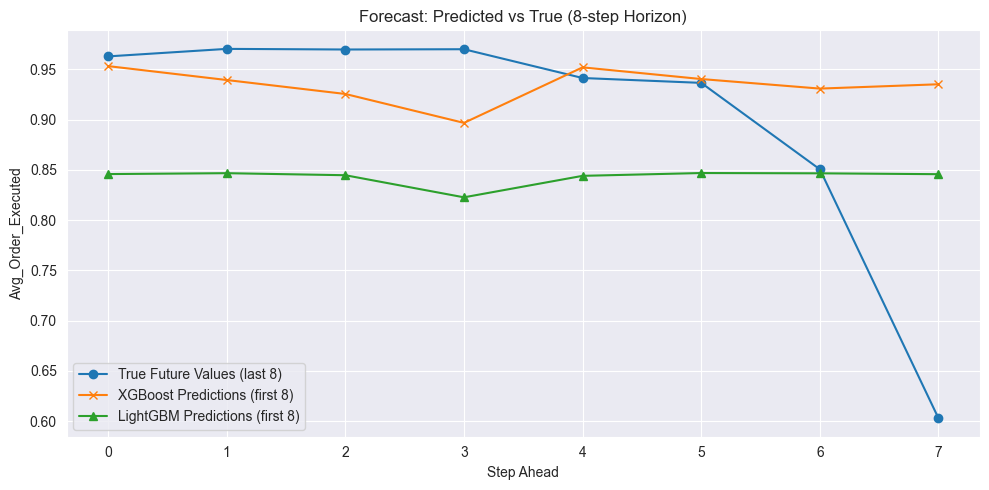

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.stattools import durbin_watson
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ── Load & preprocess ─────────────────────────────────────────────
fp24 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Prediction.csv"
fp22 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Prediction-new.csv"
data = pd.concat([pd.read_csv(fp22), pd.read_csv(fp24)], ignore_index=True)

data["timestamp"] = pd.to_datetime({
    "year":   data["Year"],
    "month":  data["Month"],
    "day":    data["Day"],
    "hour":   data["Hour"],
    "minute": data["Minute"],
    "second": data["Second"]
})
data = (
    data.sort_values("timestamp")
        .set_index("timestamp")
        .resample("15min").mean()
        .interpolate("linear")
)

# ── Feature Engineering ───────────────────────────────────────────

data.dropna(inplace=True)

# ── Target scaling ────────────────────────────────────────────────
target = data["Avg_Order_Executed"].values.reshape(-1, 1)
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target).flatten()

# ── Prepare inputs ────────────────────────────────────────────────
LAGS = 120
HORIZON = 8
feature_cols = [col for col in data.columns if col != "Avg_Order_Executed"]
feature_matrix = data[feature_cols].values

X, y = [], []
for i in range(len(data) - LAGS - HORIZON + 1):
    lag_features = target_scaled[i:i+LAGS]
    extra_features = feature_matrix[i+LAGS-1]  # current timestamp features
    combined = np.concatenate([lag_features, extra_features])
    X.append(combined)
    y.append(target_scaled[i+LAGS+HORIZON-1])
X, y = np.array(X), np.array(y)

# ── Remove last 16 rows for forecast set ──────────────────────────
n = len(X) - HORIZON*2
train_i = int(n * 0.8)
val_i   = int(n * 0.9)

X_train, y_train = X[:train_i], y[:train_i]
X_val, y_val     = X[train_i:val_i], y[train_i:val_i]
X_test, y_test   = X[val_i:n], y[val_i:n]

# ── Model Training ────────────────────────────────────────────────
import optuna

def objective_xgb(trial):
    params = {
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 8, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'verbosity': 0
    }
    model = XGBRegressor(**params, early_stopping_rounds=20)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)
    preds = model.predict(X_val)
    return r2_score(y_val, preds)

def objective_lgbm(trial):
    params = {
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50)
    }
    model = LGBMRegressor(**params, early_stopping_rounds=20)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)])
    preds = model.predict(X_val)
    return r2_score(y_val, preds)


study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=1)

study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=1)

xgb_model = XGBRegressor(**study_xgb.best_params, early_stopping_rounds=20)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

lgbm_model = LGBMRegressor(**study_lgbm.best_params, early_stopping_rounds=20)
lgbm_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)
lgbm_model.fit(X_train, y_train,
               eval_set=[(X_val, y_val)])

# ── Forecast evaluation set: last 16 rows ─────────────────────────
X_forecast_16 = X[-(HORIZON*2):]
X_predict_input = X_forecast_16[:HORIZON]        # Full 120+extra features
y_true_future = X_forecast_16[HORIZON:, :LAGS]   # Only lag part → last value
y_true_future = y_true_future[:, -1]

# Predictions
xgb_preds = xgb_model.predict(X_predict_input)
lgbm_preds = lgbm_model.predict(X_predict_input)

# ── Inverse transform for plotting ────────────────────────────────
y_true_inv = scaler.inverse_transform(y_true_future.reshape(-1, 1)).flatten()
xgb_inv = scaler.inverse_transform(xgb_preds.reshape(-1, 1)).flatten()
lgbm_inv = scaler.inverse_transform(lgbm_preds.reshape(-1, 1)).flatten()

# ── Metrics on test set ───────────────────────────────────────────
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_pred - y_true) / denom) * 100

def evaluate(name, y_true_scaled, y_pred_scaled, mase_den):
    y_true = scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    print(f"{name:<6}| MSE: {mean_squared_error(y_true, y_pred):.6f}  "
          f"MAE: {mean_absolute_error(y_true, y_pred):.6f}  "
          f"R²: {r2_score(y_true, y_pred):.4f}  "
          f"MASE: {mean_absolute_error(y_true_scaled, y_pred_scaled)/mase_den:.4f}  "
          f"SMAPE: {smape(y_true_scaled, y_pred_scaled):.2f}%  "
          f"DW: {durbin_watson(y_true_scaled - y_pred_scaled):.2f}")

mase_den_scaled = np.mean(np.abs(y_train[1:] - y_train[:-1]))

xgb_test_preds = xgb_model.predict(X_test)
lgbm_test_preds = lgbm_model.predict(X_test)

evaluate("XGB", y_test, xgb_test_preds, mase_den_scaled)
evaluate("LGBM", y_test, lgbm_test_preds, mase_den_scaled)

# ── Plot Forecast Results ─────────────────────────────────────────
plt.figure(figsize=(10, 5))
plt.plot(target[-8:], label="True Future Values (last 8)", marker='o')
plt.plot(xgb_inv, label="XGBoost Predictions (first 8)", marker='x')
plt.plot(lgbm_inv, label="LightGBM Predictions (first 8)", marker='^')
plt.title("Forecast: Predicted vs True (8-step Horizon)")
plt.xlabel("Step Ahead")
plt.ylabel("Avg_Order_Executed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Transformer Model

In [55]:
!pip install "chronos-forecasting[training] @ git+https://github.com/amazon-science/chronos-forecasting.git"
!pip install chronos-forecasting

  Cloning https://github.com/amazon-science/chronos-forecasting.git to c:\users\shalev\appdata\local\temp\pip-install-7eq90n0s\chronos-forecasting_9f091b2750aa4bed9f63dcb7f542c874
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 6a9c8dadac04eb85befc935043e3e2cce914267f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.2-py3-none-any.whl size=29539 sha256=b8c4a8dd38269d7b3080a5167bad70bc35fa1324b1a3f54fdb6d4b57f0e33076
  Stored in directory: C:\Users\Shalev\AppData\Local\Temp\pip-ephem-wheel-cache-gyb_5l1z\wheels\b9\a6\b5\75fca7306751a3bc92a63680f861f44a42a8776f6423cf0188
Successfully built chronos-forecasting

  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git 'C:\Users\Shalev\AppData\Local\Temp\pip-install-7eq90n0s\chronos-forecasting_9f091b2750aa4bed9f63dcb7f542c874'

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Chronos - T5 |  MSE: 0.000543, MAE: 0.019394, R²: 0.9614, MASE: 3.9949, SMAPE: 2.25%, DW: 0.46


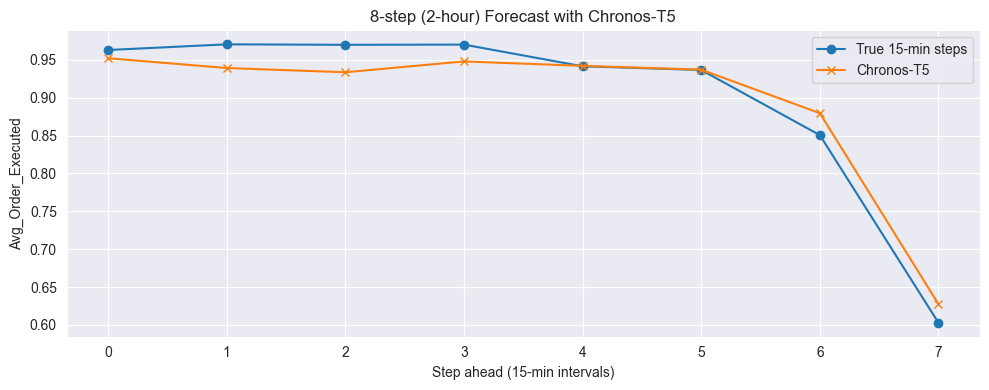

In [2]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 1. Load & concatenate CSVs
fp24 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Prediction.csv"
fp22 = r"C:\Users\Shalev\Downloads\processed_timestamp_data_Prediction-new.csv"
df = pd.concat([pd.read_csv(fp22), pd.read_csv(fp24)], ignore_index=True)

# 2. Build 15-min datetime index & fill gaps
df["timestamp"] = pd.to_datetime({
    "year": df["Year"], "month": df["Month"], "day": df["Day"],
    "hour": df["Hour"], "minute": df["Minute"], "second": df["Second"]
})
df = df.set_index("timestamp").sort_index()
df = df.resample("15min").mean().interpolate()

# 3. Split out last 12 points (3h) as hold-out
series = df["Avg_Order_Executed"].to_numpy(dtype="float64")
horizon = 8
train_vals = series[:-horizon]
test_vals = series[-horizon:]

# 4. Load Chronos-T5 transformer
pipe_t5 = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cpu"
)

# 5. Build context tensor
ctx = torch.from_numpy(train_vals).unsqueeze(0)  # shape (1, T)

# 6. Rolling (walk-forward) forecast, one step at a time
preds = []
context_vals = train_vals.copy()
for _ in range(horizon):
    ctx = torch.from_numpy(context_vals[-8192:]).unsqueeze(0)  # shape (1, T)
    raw = pipe_t5.predict(context=ctx, prediction_length=1, limit_prediction_length=True)
    arr = raw.cpu().numpy()
    if arr.ndim == 2:
        arr = arr[:, None, :]           # ensure shape (1, S, 1)
    mean_pred = arr.mean(axis=1).squeeze()  # scalar
    preds.append(mean_pred)
    context_vals = np.append(context_vals, mean_pred)

preds = np.array(preds)

# 7. Compute metrics on the rolling forecasts
mse = mean_squared_error(test_vals, preds)
mae = mean_absolute_error(test_vals, preds)
r2  = r2_score(test_vals, preds)

from statsmodels.stats.stattools import durbin_watson

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_pred - y_true) / denom) * 100

def mase(y_true, y_pred, insample):
    naive_errors = np.abs(insample[1:] - insample[:-1])
    denom = np.mean(naive_errors)
    return mean_absolute_error(y_true, y_pred) / denom

dw = durbin_watson(test_vals - preds)
smp = smape(test_vals, preds)
mase_val = mase(test_vals, preds, train_vals)

print("Chronos - T5 | ",f"MSE: {mse:.6f}, MAE: {mae:.6f}, R²: {r2:.4f}, MASE: {mase_val:.4f}, SMAPE: {smp:.2f}%, DW: {dw:.2f}")


# 10. Plot the last part of the training series plus the forecasts
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# x-axis for the horizon (0 … 11)
h_idx = np.arange(horizon)

# plot the ground-truth hold-out points
plt.plot(h_idx, test_vals, marker='o', label="True 15-min steps")

# plot mean and median forecasts
plt.plot(h_idx, preds,  marker='x', label="Chronos-T5")


plt.title("8-step (2-hour) Forecast with Chronos-T5")
plt.xlabel("Step ahead (15-min intervals)")
plt.ylabel("Avg_Order_Executed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


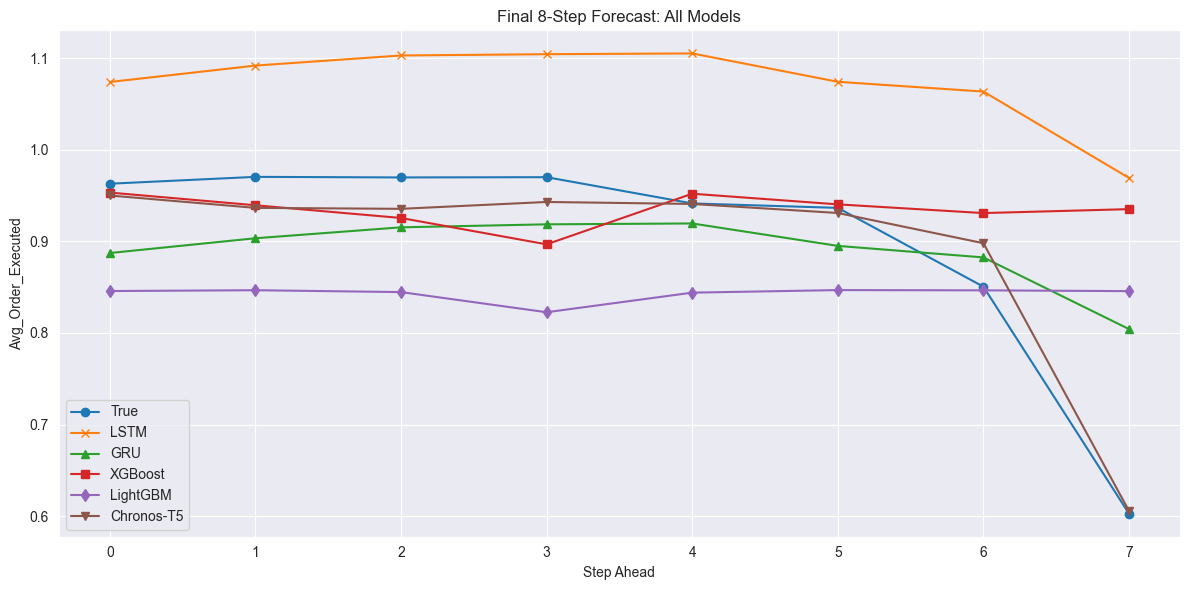

In [18]:
plt.figure(figsize=(12, 6))

# True values (use from one consistent source)
plt.plot(range(8), test_vals, label="True", marker='o')

# LSTM and GRU
plt.plot(range(8), scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)) / 1000, label="LSTM", marker='x')
plt.plot(range(8), scaler.inverse_transform(gru_preds_scaled.reshape(-1, 1)) / 1000, label="GRU", marker='^')

# XGBoost and LightGBM
plt.plot(range(8), xgb_inv, label="XGBoost", marker='s')
plt.plot(range(8), lgbm_inv, label="LightGBM", marker='d')

# Chronos-T5
plt.plot(np.arange(horizon), preds, label="Chronos-T5", marker='v')

plt.title("Final 8-Step Forecast: All Models")
plt.xlabel("Step Ahead")
plt.ylabel("Avg_Order_Executed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Shalev\AppData\Local\Temp\ipykernel_24468\2106567118.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start=five_years_ago.strftime("%Y-%m-%d"), end=today.strftime("%Y-%m-%d"))
[*********************100%***********************]  1 of 1 completed

Found 3 tickers with ≥3 % drop today.


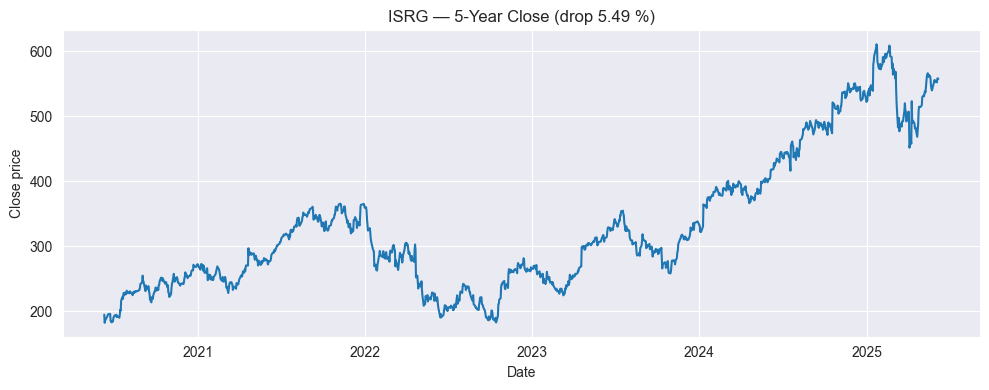

C:\Users\Shalev\AppData\Local\Temp\ipykernel_24468\2106567118.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start=five_years_ago.strftime("%Y-%m-%d"), end=today.strftime("%Y-%m-%d"))
[*********************100%***********************]  1 of 1 completed


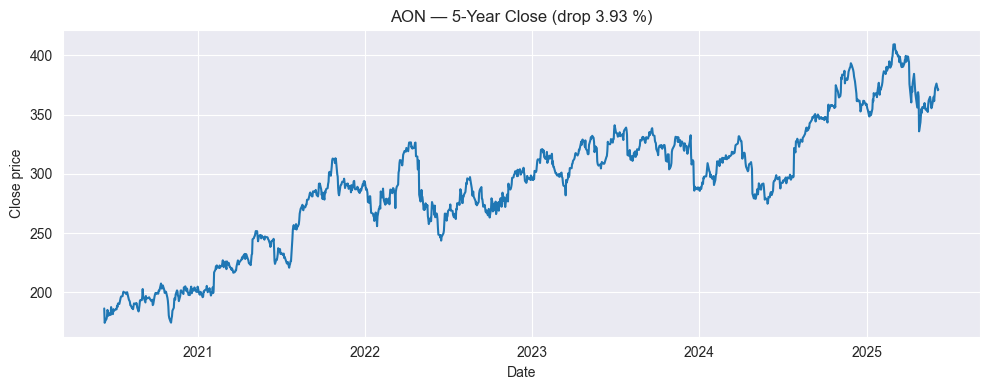

C:\Users\Shalev\AppData\Local\Temp\ipykernel_24468\2106567118.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start=five_years_ago.strftime("%Y-%m-%d"), end=today.strftime("%Y-%m-%d"))
[*********************100%***********************]  1 of 1 completed


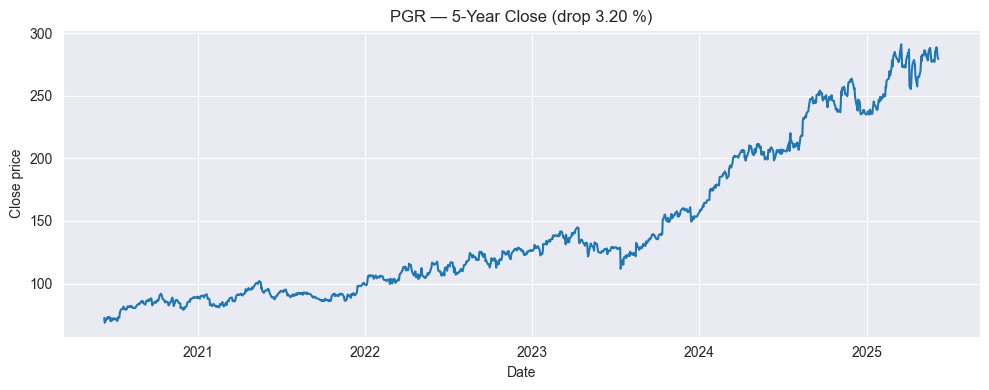

[*********************100%***********************]  1 of 1 completed


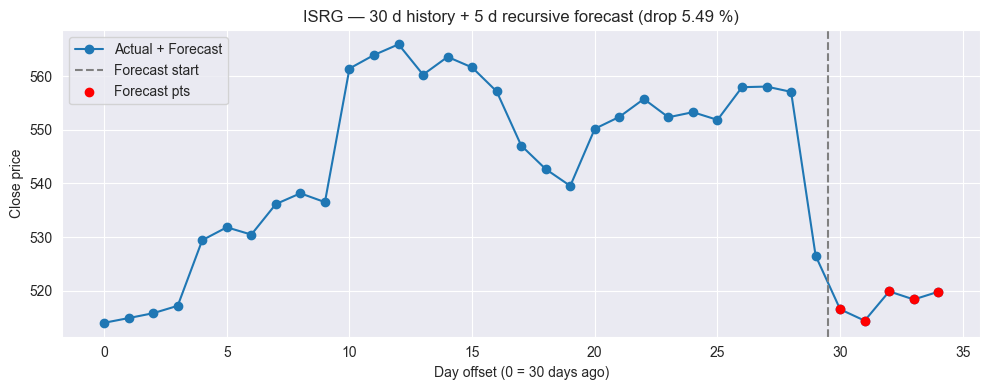

[*********************100%***********************]  1 of 1 completed


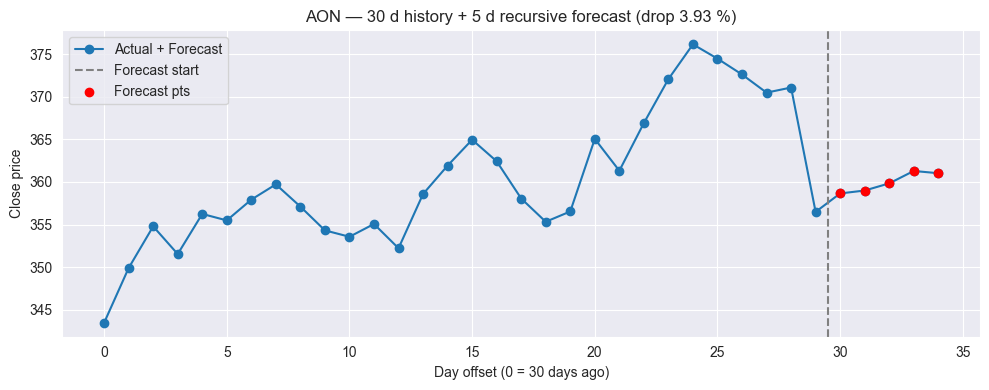

[*********************100%***********************]  1 of 1 completed


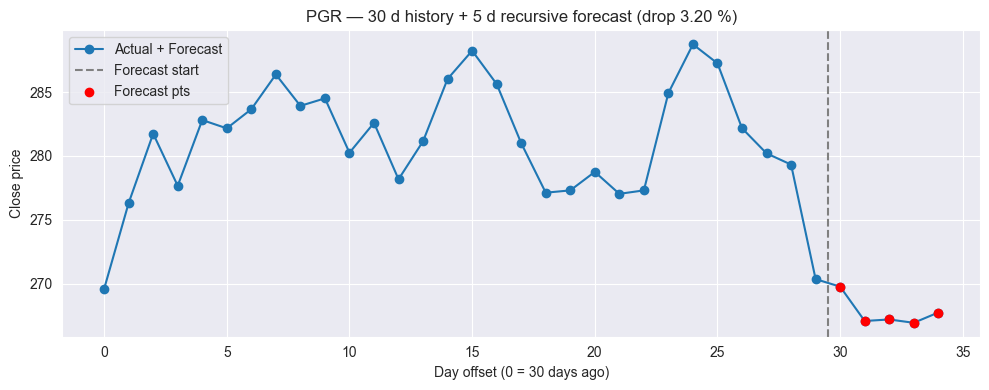

In [10]:
"""
Full Script with Recursive Forecasting
======================================
• Detect stocks with ≥3% daily drop
• Plot 5-year price history
• Forecast next 5 days recursively (1-step → feed → 1-step ...)
• Plot last 30 days + 5-day forecast using Chronos-T5

Requires:
    pip install yfinance matplotlib torch chronos
"""

import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import torch
import numpy as np
from chronos import ChronosPipeline
import traceback

# ---------------------- 1. Tickers ----------------------
tickers = [
    "AAPL","MSFT","AMZN","GOOGL","META","TSLA","NVDA","JPM","JNJ","UNH","HD","V","MA","PG","BAC",
    "XOM","KO","PFE","CSCO","INTC","VZ","CVX","WMT","MCD","AMD","NFLX","DIS","PEP","ABT","MRK",
    "CRM","ADBE","T","ORCL","TMUS","COST","SBUX","LLY","NKE","QCOM","TXN","LOW","VRTX","GILD",
    "MDT","AMGN","HON","MMM","PLD","SPG","F","GM","BA","CAT","BKNG","NOW","ISRG","EL","ZTS","LMT",
    "DE","DHR","MDLZ","BLK","ADP","PYPL","SYK","SCHW","TMO","MO","CI","C","CL","ETN","ECL","APD",
    "BDX","EMR","ICE","WM","ADI","NSC","DUK","USB","HUM","AXP","FDX","AON","WBA","SO","PGR","CME",
    "HCA","AIG","ITW","MCO","SRE","PSX","KMB","REGN","ROST","EBAY"
]

# ---------------------- 2. Detect Drops ----------------------
today = datetime.today()
five_years_ago = today - timedelta(days=5*365)
drop_stocks = []

for tkr in tickers:
    try:
        hist = yf.Ticker(tkr).history(period="6d")
        if hist.empty or len(hist) < 2:
            continue
        pct_drop = (hist['Close'].iloc[-2] - hist['Close'].iloc[-1]) / hist['Close'].iloc[-2] * 100
        if pct_drop >= 3:
            drop_stocks.append((tkr, pct_drop))
    except Exception:
        continue

print(f"Found {len(drop_stocks)} tickers with ≥3 % drop today.")

# ---------------------- 3. Plot 5-Year History ----------------------
for sym, pct in drop_stocks:
    try:
        df = yf.download(sym, start=five_years_ago.strftime("%Y-%m-%d"), end=today.strftime("%Y-%m-%d"))
        if df.empty:
            continue
        plt.figure(figsize=(10,4))
        plt.plot(df.index, df["Close"])
        plt.title(f"{sym} — 5-Year Close (drop {pct:.2f} %)")
        plt.xlabel("Date")
        plt.ylabel("Close price")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception:
        continue

# ---------------------- 4. Chronos Recursive Forecast ----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe_t5 = ChronosPipeline.from_pretrained("amazon/chronos-t5-large", device_map=device)

for sym, pct in drop_stocks:
    try:
        df = yf.download(sym, period="5y", auto_adjust=False)
        closes = df["Close"].dropna().to_numpy(dtype="float32")
        if closes.size < 60:
            continue

        # Step-by-step (recursive) forecasting for 5 days
        forecast = []
        context_vals = closes.copy()

        for _ in range(5):
            ctx_vals = context_vals[-1000:].reshape(1, -1)
            ctx = torch.from_numpy(ctx_vals).to(device)

            preds = pipe_t5.predict(ctx, prediction_length=1, limit_prediction_length=True)
            pred_np = preds.cpu().numpy()

            if pred_np.ndim == 3:
                next_val = pred_np[0].mean(axis=0)[0]
            elif pred_np.ndim == 2:
                next_val = pred_np.mean(axis=0)[0]
            else:
                next_val = float(pred_np.squeeze())

            forecast.append(next_val)
            context_vals = np.append(context_vals, next_val)

        # Plot last 30 days + forecast
        last30 = closes[-30:].flatten()
        full_series = np.concatenate([last30, forecast])
        x_full = range(len(full_series))

        plt.figure(figsize=(10, 4))
        plt.plot(x_full, full_series, marker='o', label="Actual + Forecast")
        plt.axvline(29.5, color='gray', linestyle='--', label="Forecast start")
        plt.scatter(range(30, 35), forecast, color='red', label="Forecast pts", zorder=5)

        plt.title(f"{sym} — 30 d history + 5 d recursive forecast (drop {pct:.2f} %)")
        plt.xlabel("Day offset (0 = 30 days ago)")
        plt.ylabel("Close price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        traceback.print_exc()
        print(f"{sym}: forecast error → {e}")
        continue
